In [29]:
import os
import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt



In [30]:
# ==================================================
# Dataset Personalizado
# ==================================================
class DefectDataset(Dataset):
    def __init__(self, root_dir, transform=None, augment_NOK=False):
        self.root_dir = root_dir
        self.transform = transform
        self.augment_NOK = augment_NOK
        self.data = []
        self._load_data()
    
    def _load_data(self):
        for folder in sorted(os.listdir(self.root_dir)):
            folder_path = os.path.join(self.root_dir, folder)
            if not os.path.isdir(folder_path):
                continue
            
            images = sorted(glob.glob(os.path.join(folder_path, "Part*.jpg")))
            masks = sorted(glob.glob(os.path.join(folder_path, "Part*_label.bmp")))
            
            for img_path, mask_path in zip(images, masks):
                mask = Image.open(mask_path).convert("L")
                mask_array = torch.tensor(list(mask.getdata())).reshape(mask.size)
                label = 1 if mask_array.max() > 0 else 0
                self.data.append((img_path, label))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


# ==================================================
# Configuración de Transformaciones y Dataset
# ==================================================
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

root_dir = "Imagenes_defectos2"

# Crear el dataset
dataset = DefectDataset(root_dir=root_dir, transform=transform)

# Dividir el dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# ==================================================
# Definición del Modelo
# ==================================================
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 64 * 64, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


# ==================================================
# Entrenamiento y Validación
# ==================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Entrenando"):
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Pérdida de entrenamiento: {train_loss:.4f}")
        validate_model(model, val_loader, criterion)


def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            predictions = (outputs > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    val_loss /= len(val_loader)
    accuracy = 100 * correct / total
    print(f"Pérdida de validación: {val_loss:.4f}, Precisión: {accuracy:.2f}%")


train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


# ==================================================
# Evaluación
# ==================================================
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            predictions = (outputs > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    print(f"Precisión en el conjunto de prueba: {accuracy:.2f}%")


test_model(model, test_loader)


Epoch 1/10 - Entrenando: 100%|██████████| 32/32 [00:07<00:00,  4.20it/s]


Epoch 1/10, Pérdida de entrenamiento: 1.1991
Pérdida de validación: 0.6515, Precisión: 49.30%


Epoch 2/10 - Entrenando: 100%|██████████| 32/32 [00:07<00:00,  4.50it/s]


Epoch 2/10, Pérdida de entrenamiento: 0.4393
Pérdida de validación: 0.2428, Precisión: 90.85%


Epoch 3/10 - Entrenando: 100%|██████████| 32/32 [00:07<00:00,  4.44it/s]


Epoch 3/10, Pérdida de entrenamiento: 0.1606
Pérdida de validación: 0.1995, Precisión: 97.18%


Epoch 4/10 - Entrenando: 100%|██████████| 32/32 [00:07<00:00,  4.45it/s]


Epoch 4/10, Pérdida de entrenamiento: 0.0404
Pérdida de validación: 0.1725, Precisión: 95.07%


Epoch 5/10 - Entrenando: 100%|██████████| 32/32 [00:07<00:00,  4.43it/s]


Epoch 5/10, Pérdida de entrenamiento: 0.0039
Pérdida de validación: 0.1224, Precisión: 98.59%


Epoch 6/10 - Entrenando: 100%|██████████| 32/32 [00:07<00:00,  4.49it/s]


Epoch 6/10, Pérdida de entrenamiento: 0.0012
Pérdida de validación: 0.7547, Precisión: 97.18%


Epoch 7/10 - Entrenando: 100%|██████████| 32/32 [00:07<00:00,  4.52it/s]


Epoch 7/10, Pérdida de entrenamiento: 0.0004
Pérdida de validación: 0.1274, Precisión: 99.30%


Epoch 8/10 - Entrenando: 100%|██████████| 32/32 [00:06<00:00,  4.58it/s]


Epoch 8/10, Pérdida de entrenamiento: 0.0002
Pérdida de validación: 0.1292, Precisión: 98.59%


Epoch 9/10 - Entrenando: 100%|██████████| 32/32 [00:07<00:00,  4.50it/s]


Epoch 9/10, Pérdida de entrenamiento: 0.0002
Pérdida de validación: 0.1345, Precisión: 98.59%


Epoch 10/10 - Entrenando: 100%|██████████| 32/32 [00:06<00:00,  4.59it/s]


Epoch 10/10, Pérdida de entrenamiento: 0.0002
Pérdida de validación: 0.1330, Precisión: 98.59%
Precisión en el conjunto de prueba: 97.22%


In [31]:
print(len(dataset))

711


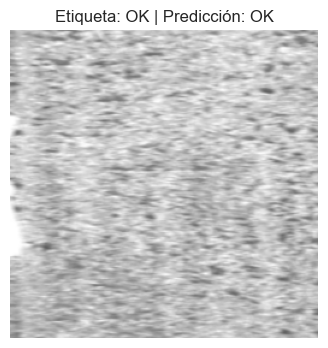

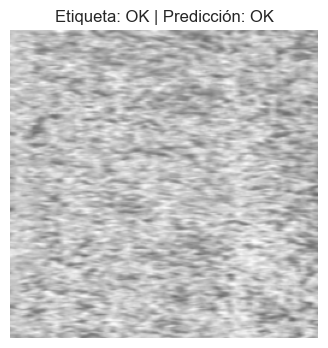

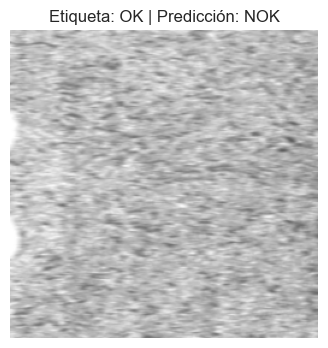

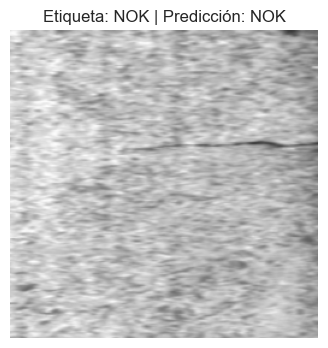

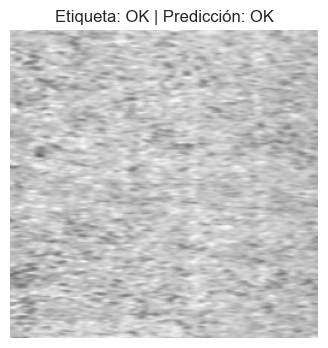

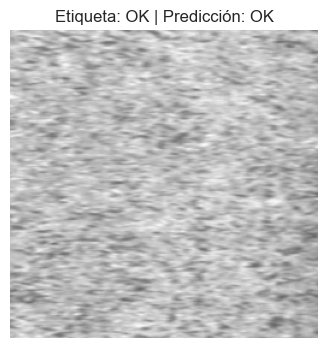

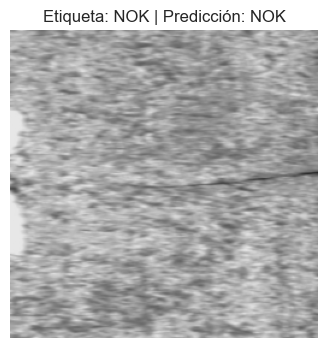

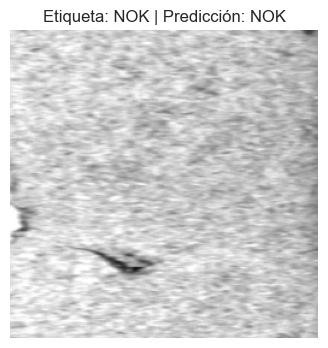

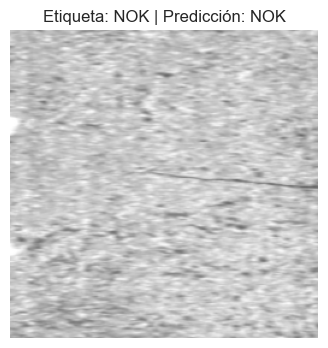

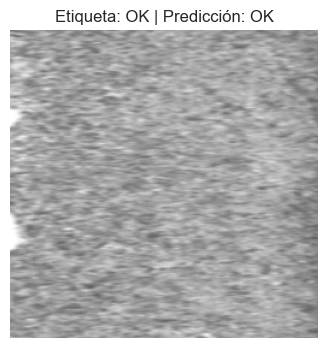


Resultados del Modelo:
Imágenes OK correctamente clasificadas: 34
Imágenes OK mal clasificadas: 2
Imágenes NOK correctamente clasificadas: 36
Imágenes NOK mal clasificadas: 0
Precisión total: 97.22%


In [32]:
# ==================================================
# Evaluación con Conteo de OK y NOK
# ==================================================
def evaluate_and_visualize(model, test_loader, num_visualizations=10):
    """
    Conteo de imágenes bien y mal clasificadas.
    """
    model.eval()
    ok_correct = 0
    ok_incorrect = 0
    nok_correct = 0
    nok_incorrect = 0
    total = 0
    images_visualized = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            predictions = (outputs > 0.5).float()  # Predicciones binarias
            
            # Conteo de OK y NOK correctamente e incorrectamente clasificadas
            for i in range(labels.size(0)):
                if labels[i].item() == 0:  # OK
                    if predictions[i].item() == 0:
                        ok_correct += 1
                    else:
                        ok_incorrect += 1
                else:  # NOK
                    if predictions[i].item() == 1:
                        nok_correct += 1
                    else:
                        nok_incorrect += 1
                
                # Visualización de imágenes
                if images_visualized < num_visualizations:
                    visualize_image(images[i], labels[i].item(), predictions[i].item())
                    images_visualized += 1
            
            total += labels.size(0)

    # Imprimir resultados
    print("\nResultados del Modelo:")
    print(f"Imágenes OK correctamente clasificadas: {ok_correct}")
    print(f"Imágenes OK mal clasificadas: {ok_incorrect}")
    print(f"Imágenes NOK correctamente clasificadas: {nok_correct}")
    print(f"Imágenes NOK mal clasificadas: {nok_incorrect}")
    print(f"Precisión total: {(ok_correct + nok_correct) / total * 100:.2f}%")

# ==================================================
# Visualización de Imágenes
# ==================================================
def visualize_image(image, label, prediction):
    """
    Muestrar una imagen con su etiqueta real y predicción.
    """
    image = image.cpu().permute(1, 2, 0)  # Convertir a formato HWC para matplotlib
    image = image * 0.5 + 0.5  # Revertir la normalización (mean=0.5, std=0.5)

    plt.figure(figsize=(4, 4))
    plt.imshow(image.numpy())
    plt.title(f"Etiqueta: {'OK' if label == 0 else 'NOK'} | Predicción: {'OK' if prediction == 0 else 'NOK'}")
    plt.axis('off')
    plt.show()


# ==================================================
# Evaluar y Visualizar
# ==================================================
evaluate_and_visualize(model, test_loader, num_visualizations=10)


In [33]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

def evaluate_with_confusion_matrix(model, test_loader):
    """
    Evalúa el modelo y genera una matriz de confusión.
    """
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            predictions = (outputs > 0.5).float()

            # Guardar etiquetas reales y predicciones
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    # Calcular matriz de confusión
    cm = confusion_matrix(all_labels, all_predictions, labels=[0, 1])  # Etiquetas: 0 = OK, 1 = NOK
    plot_confusion_matrix(cm, classes=['OK', 'NOK'])


def plot_confusion_matrix(cm, classes):
    """
    Muestra una matriz de confusión como un gráfico.
    """
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Real')
    plt.title('Matriz de Confusión')
    plt.show()

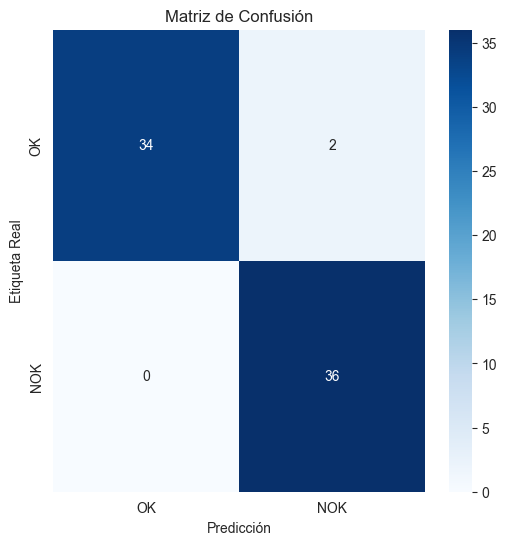

In [34]:
evaluate_with_confusion_matrix(model, test_loader)

In [35]:
from sklearn.metrics import confusion_matrix, classification_report

def calculate_f1_score(model, test_loader):
    """
    Calcular el F1-score, precisión y recall del modelo usando el conjunto de prueba.
    """
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            predictions = (outputs > 0.5).float()

            # Guardar etiquetas reales y predicciones
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    # Calcular matriz de confusión
    cm = confusion_matrix(all_labels, all_predictions, labels=[0, 1])
    print("Matriz de Confusión:")
    print(cm)

    # Generar reporte de métricas
    report = classification_report(all_labels, all_predictions, target_names=["OK", "NOK"])
    print("\nReporte de Clasificación:")
    print(report)


In [36]:
def find_and_analyze_misclassified(model, test_loader, num_visualizations=10):
    """
    Encontrar las imágenes mal clasificadas
    """
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            predictions = (outputs > 0.5).float()

            # Identificar las imágenes mal clasificadas
            for i in range(labels.size(0)):
                if predictions[i].item() != labels[i].item():
                    misclassified.append((images[i], labels[i].item(), predictions[i].item()))

    # Visualizar las imágenes mal clasificadas
    visualize_misclassified(misclassified, num_visualizations)


def visualize_misclassified(misclassified, num_visualizations):
    """
    Visualizar imágenes mal clasificadas con etiquetas reales y predicciones.
    """
    for i, (image, label, prediction) in enumerate(misclassified[:num_visualizations]):
        image = image.cpu().permute(1, 2, 0)  # Convertir a formato HWC para matplotlib
        image = image * 0.5 + 0.5  # Revertir la normalización (mean=0.5, std=0.5)

        plt.figure(figsize=(4, 4))
        plt.imshow(image.numpy())
        plt.title(f"Etiqueta: {'OK' if label == 0 else 'NOK'} | Predicción: {'OK' if prediction == 0 else 'NOK'}")
        plt.axis('off')
        plt.show()


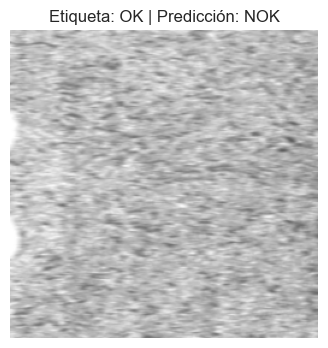

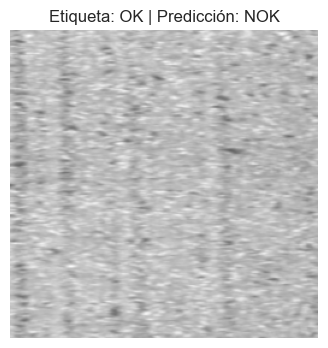

In [37]:
find_and_analyze_misclassified(model, test_loader, num_visualizations=10)


In [38]:
calculate_f1_score(model, test_loader)


Matriz de Confusión:
[[34  2]
 [ 0 36]]

Reporte de Clasificación:
              precision    recall  f1-score   support

          OK       1.00      0.94      0.97        36
         NOK       0.95      1.00      0.97        36

    accuracy                           0.97        72
   macro avg       0.97      0.97      0.97        72
weighted avg       0.97      0.97      0.97        72



In [39]:
# ==================================================
# Guardar el modelo entrenado
# ==================================================
def save_model(model, optimizer, path="modelo.pkl"):
    """
    Guardar el modelo y el optimizador en un archivo .pkl.
    """
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, path)
    print(f"Modelo guardado en {path}")


In [40]:
save_model(model, optimizer, path="simple_cnn_model_data_aug.pkl")

Modelo guardado en simple_cnn_model_data_aug.pkl


In [49]:
# Visualización de la cantidad de imágenes OK y NOK
def visualize_image_counts(dataset):
    labels = [label for _, label in dataset]
    ok_count = labels.count(0)
    nok_count = labels.count(1)

    plt.bar(["OK", "NOK"], [ok_count, nok_count], color=["blue", "darkblue"])
    plt.xlabel("Clase")
    plt.ylabel("Cantidad de Imágenes")
    plt.title("Distribución de Imágenes OK y NOK")
    plt.show()

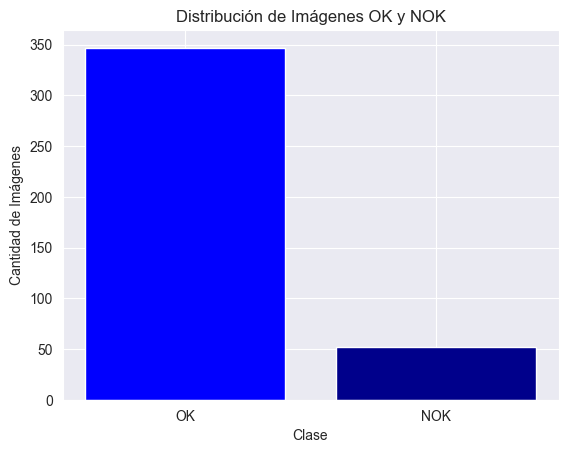

In [50]:
visualize_image_counts(dataset)

In [51]:
root_dir = "Imagenes_defectos2"

# Crear el dataset
dataset = DefectDataset(root_dir=root_dir, transform=transform)

In [54]:
# Visualización de la cantidad de imágenes OK y NOK
def visualize_image_counts(dataset):
    labels = [label for _, label in dataset]
    ok_count = labels.count(0)
    nok_count = labels.count(1)

    plt.bar(["OK", "NOK"], [ok_count, nok_count], color=["blue", "darkblue"])
    plt.xlabel("Clase")
    plt.ylabel("Cantidad de Imágenes")
    plt.title("Distribución de Imágenes OK y NOK")
    plt.show()

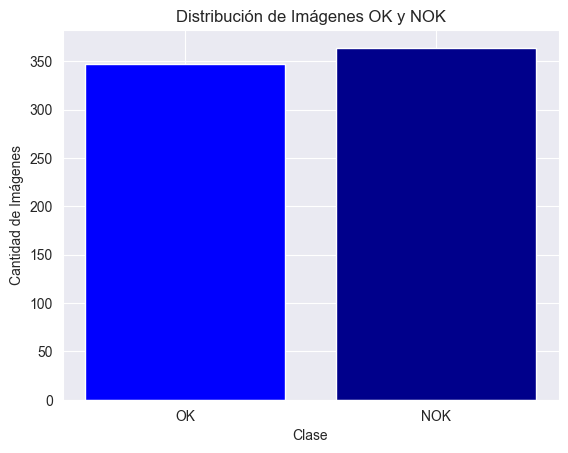

In [55]:
visualize_image_counts(dataset)

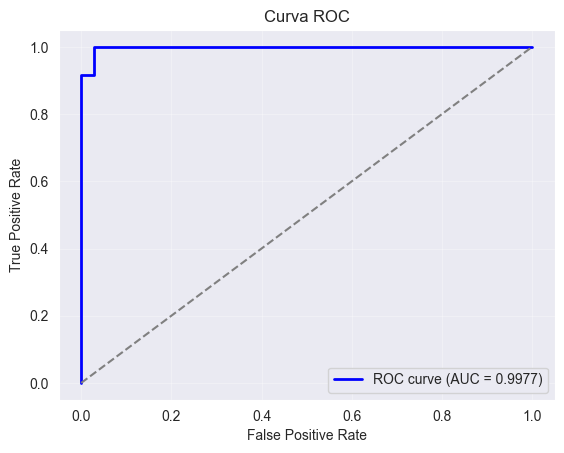

AUC: 0.9977


In [63]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(model, data_loader):
    """
    Genera la curva ROC y calcula el AUC para el modelo.
    """
    model.eval()  
    all_labels = []
    all_probs = []

    with torch.no_grad():  # Desactivar cálculo de gradientes
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device).float()
            labels = labels.view(-1, 1)  # Ajustar las dimensiones de las etiquetas
            
            outputs = model(images)  # Forward pass
            probabilities = outputs.cpu().numpy()  # Convertir a numpy
            
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities)

    # Calcular la curva ROC
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Generar la gráfica
    plt.figure()
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Línea base
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Curva ROC")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

    print(f"AUC: {roc_auc:.4f}")
    return roc_auc

# Llamar a la función con el conjunto de validación o prueba
roc_auc = plot_roc_curve(model, test_loader)  